In [2]:
# SECCIÓN 1 - Importaciones e inicialización
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.sparse import lil_matrix
import pandas as pd
from IPython.display import display, HTML

# Configuración de la malla
rows = 10  # Número de filas (incluyendo bordes)
cols = 100  # Número de columnas (incluyendo bordes)

# Crear malla de coordenadas
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Inicialización de las velocidades
vx = np.zeros((rows, cols))  # Velocidad en dirección x
vy = np.zeros((rows, cols))  # Velocidad en dirección y

# Condiciones de frontera modificadas para 10x100
vx[0, :] = 0; vx[-1, :] = 0
vy[0, :] = 0; vy[-1, :] = 0
vx[1:9, 0] = 1  # Ajustado para 10 filas
vx[0, 0] = 0
vx[9, 0] = 0
vy[:, 0] = 0  # Cambiado a 0 para estabilidad
vx[:, -1] = 0
vy[:, -1] = 0

# Condición inicial en puntos internos - interpolación lineal
for i in range(1, rows-1):
    for j in range(1, cols-1):
        vx[i, j] = 1.0 * (1 - j / (cols-1))  # Interpolación lineal
        vy[i, j] = 0


def calculate_F(vx, h=1.0):
    rows, cols = vx.shape
    F = np.zeros((rows-2, cols-2))
    vy_const = 0.1
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            term1 = vx[i+1,j] + vx[i-1,j] + vx[i,j+1] + vx[i,j-1]
            term2 = (h/2) * vx[i,j] * (vx[i+1,j] - vx[i-1,j])
            term3 = (h/2) * vy_const * (vx[i,j+1] - vx[i,j-1])
            vx_calculated = vx[i,j] - (1/4) * (term1 - term2 - term3)
            F[i-1, j-1] = vx_calculated
    return F


def calculate_Jacobian_sparse(vx, h=1.0):
    rows, cols = vx.shape
    n = (rows-2) * (cols-2)
    J = lil_matrix((n, n))
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            idx = (i-1)*(cols-2) + (j-1)
            J[idx, idx] = 1 + (h/8)*(vx[i+1,j] - vx[i-1,j]) + (h/8)*vy[i,j]*(vx[i,j+1] - vx[i,j-1])
            
            if i > 1:
                J[idx, idx - (cols-2)] = -0.25 + (h/8)*vx[i,j]
            if i < rows-2:
                J[idx, idx + (cols-2)] = -0.25 - (h/8)*vx[i,j]
            if j > 1:
                J[idx, idx - 1] = -0.25 + (h/8)*0.1
            if j < cols-2:
                J[idx, idx + 1] = -0.25 - (h/8)*0.1
    return J

In [3]:
# SECCIÓN 2 - Número de condición
cond_number = np.linalg.cond(calculate_Jacobian_sparse(vx).toarray())
print("Número de condición:", cond_number)

Número de condición: 60.03863056730493


In [4]:
# SECCIÓN 3 - Mostrar tabla de velocidades
def mostrar_tabla_velocidades(X, num_cols=20):
    tabla = X[1:-1, 1:-1].reshape((rows-2, cols-2))
    df = pd.DataFrame(tabla, index=[f"Fila {i+1}" for i in range(rows-2)],
                      columns=[f"Col {j+1}" for j in range(cols-2)])
    print("\nTabla de velocidades en la malla interna:\n")
    print(f"Mostrando primeras {min(num_cols, cols-2)} columnas:")
    print(df.iloc[:, :num_cols].round(4))
    return df

mostrar_tabla_velocidades(vx)


Tabla de velocidades en la malla interna:

Mostrando primeras 20 columnas:
         Col 1   Col 2   Col 3   Col 4   Col 5   Col 6   Col 7   Col 8  \
Fila 1  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 2  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 3  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 4  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 5  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 6  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 7  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   
Fila 8  0.9899  0.9798  0.9697  0.9596  0.9495  0.9394  0.9293  0.9192   

         Col 9  Col 10  Col 11  Col 12  Col 13  Col 14  Col 15  Col 16  \
Fila 1  0.9091   0.899  0.8889  0.8788  0.8687  0.8586  0.8485  0.8384   
Fila 2  0.9091   0.899  0.8889  0.8788  0.8687  0.8586  0.8485  0.8384   
Fila 3  0.9091   0.899  0.8889  0.8

,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,Col 10,...,Col 89,Col 90,Col 91,Col 92,Col 93,Col 94,Col 95,Col 96,Col 97,Col 98
Fila 1,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 2,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 3,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 4,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 5,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 6,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 7,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101
Fila 8,0.989899,0.979798,0.969697,0.959596,0.949495,0.939394,0.929293,0.919192,0.909091,0.89899,...,0.10101,0.090909,0.080808,0.070707,0.060606,0.050505,0.040404,0.030303,0.020202,0.010101


In [ ]:
# SECCIÓN 4 - Mostrar Jacobiano
def mostrar_jacobiano(J, rows=20, cols=20):

    J_dense = J.toarray()
    
    df = pd.DataFrame(J_dense)
    

    print("Jacobiano (parcial):")
    with pd.option_context('display.max_rows', 20, 'display.max_columns', 20):
        display(df.iloc[:rows, :cols])

J = calculate_Jacobian_sparse(vx)
mostrar_jacobiano(J)

Jacobiano (parcial):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.123737,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,-0.237500,1.122475,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.000000,-0.237500,1.121212,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,-0.237500,1.119949,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,-0.237500,1.118687,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,0.000000,0.000000,0.000000,0.000000,-0.237500,1.117424,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,-0.237500,1.116162,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.237500,1.114899,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.237500,1.113636,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.237500,1.112374,-0.262500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [ ]:
# SECCIÓN 5 - Verificar convergencia Richardson
def verifica_convergencia_richardson(A):
    A = np.array(A, dtype=float)
    I = np.eye(A.shape[0])     
    Q = np.eye(A.shape[0])    
    
    try:
        Q_inv = np.linalg.inv(Q)       
        B = I - Q_inv @ A             
        norma_inf = np.linalg.norm(B, ord=np.inf)  # Norma infinito
        
        print(f"Norma infinito de (I - Q^(-1) * A): {norma_inf:.6f}")
        if norma_inf <= 1:
            print("✅ El método puede converger (norma < 1)")
        else:
            print("❌ El método no garantiza convergencia (norma >= 1)")
    except np.linalg.LinAlgError:
        print("❌ No se pudo invertir la matriz Q (puede no ser invertible)")

verifica_convergencia_richardson(calculate_Jacobian_sparse(vx).toarray())


Norma infinito de (I - Q^(-1) * A): 1.000000
✅ El método puede converger (norma < 1)


In [7]:
# SECCIÓN 6 - Verificar convergencia Jacobi
def verificar_convergencia_jacobi(A):
    n = A.shape[0]
    
    # Mostrar submatrices si A es grande
    show_size = 5 if n > 10 else n
    D = np.diag(np.diag(A))
    
    try:
        D_inv = np.linalg.inv(D)
    except np.linalg.LinAlgError:
        raise ValueError("Matriz D no es invertible. El método de Jacobi no puede aplicarse.")
    
    # Calcular matriz de iteración de Jacobi: M = I - D⁻¹A
    M = np.eye(n) - D_inv @ A
    
    # Calcular la norma infinita de M
    norma = np.linalg.norm(M, ord=np.inf)
    print(f"\nNorma ‖M‖∞ = {norma:.6f}")
    if norma <= 1:
        print("✅ El método puede converger (norma < 1)")
    else:
        print("❌ El método no garantiza convergencia (norma >= 1)")
    
    return norma <= 1, norma

verificar_convergencia_jacobi(calculate_Jacobian_sparse(vx).toarray())


Norma ‖M‖∞ = 1.000000
✅ El método puede converger (norma < 1)


(np.True_, np.float64(1.0))

In [8]:
# SECCIÓN 7 - Verificar dominancia diagonal
def es_diagonalmente_dominante(A, estricta=False, por_filas=True):
    if A.shape[0] != A.shape[1]:
        raise ValueError("La matriz debe ser cuadrada")
    
    n = A.shape[0]
    
    if por_filas:
        for i in range(n):
            diag = abs(A[i, i])
            suma = np.sum(np.abs(A[i, :])) - diag  # Suma de los elementos no diagonales
            
            if estricta:
                if diag <= suma:
                    return False
            else:
                if diag < suma:
                    return False
    else:
        for j in range(n):
            diag = abs(A[j, j])
            suma = np.sum(np.abs(A[:, j])) - diag  # Suma de los elementos no diagonales
            
            if estricta:
                if diag <= suma:
                    return False
            else:
                if diag < suma:
                    return False
    
    return True

print(f"¿Es diagonalmente dominante?: {es_diagonalmente_dominante(calculate_Jacobian_sparse(vx).toarray())}")


¿Es diagonalmente dominante?: True


In [9]:
# SECCIÓN 8 - Analizar matriz
def analizar_matriz(A):
    # Verificar si A es simétrica
    simetrica = np.allclose(A, A.T)
    
    # Obtener autovalores
    autovalores = np.linalg.eigvals(A)
    
    # Verificar definida positiva o negativa
    if np.all(autovalores > 0):
        tipo = "Definida positiva"
    elif np.all(autovalores < 0):
        tipo = "Definida negativa"
    elif np.any(autovalores > 0) and np.any(autovalores < 0):
        tipo = "Indefinida (punto de silla)"
    else:
        tipo = "Semidefinida"
    
    return {
        "Simetrica": simetrica,
        "Tipo de matriz": tipo,
    }

print(analizar_matriz(calculate_Jacobian_sparse(vx, h=1.0).toarray()))

{'Simetrica': False, 'Tipo de matriz': 'Definida positiva'}


In [10]:
# SECCIÓN 9 - Crear copias para diferentes métodos
vx_copy_LU = vx.copy()
vx_copy_jacobian = vx.copy()
vx_copy_gauss = vx.copy()
vx_copy_richardson = vx.copy()

In [11]:
# SECCIÓN 10 - Método LU OPTIMIZADO
print("\n=== MÉTODO LU OPTIMIZADO ===")
vx_copy_LU = vx.copy()

def solve_LU_scipy(A, B):
    """
    Resuelve el sistema usando scipy para mayor eficiencia
    """
    from scipy.linalg import lu_solve, lu_factor
    try:
        lu, piv = lu_factor(A)
        return lu_solve((lu, piv), B)
    except:
        return np.linalg.lstsq(A, B, rcond=None)[0]

max_iter = 100  # Reducido
iter_LU = 0

for it in range(max_iter):
    F = calculate_F(vx_copy_LU).flatten()
    J = calculate_Jacobian_sparse(vx_copy_LU)
    
    # Usar scipy para resolver eficientemente
    delta_X = solve_LU_scipy(J.toarray(), -F) * 0.3  # Factor de amortiguación
    
    # Actualizar vx
    vx_copy_LU[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_LU = it + 1
        break
    
    print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_LU = max_iter



=== MÉTODO LU OPTIMIZADO ===
Iteración 1: ||ΔX|| = 3.446e+00
Iteración 2: ||ΔX|| = 2.931e+00
Iteración 3: ||ΔX|| = 2.390e+00
Iteración 4: ||ΔX|| = 1.860e+00
Iteración 5: ||ΔX|| = 1.387e+00
Iteración 6: ||ΔX|| = 1.001e+00
Iteración 7: ||ΔX|| = 7.073e-01
Iteración 8: ||ΔX|| = 4.940e-01
Iteración 9: ||ΔX|| = 3.432e-01
Iteración 10: ||ΔX|| = 2.379e-01
Iteración 11: ||ΔX|| = 1.650e-01
Iteración 12: ||ΔX|| = 1.145e-01
Iteración 13: ||ΔX|| = 7.960e-02
Iteración 14: ||ΔX|| = 5.543e-02
Iteración 15: ||ΔX|| = 3.867e-02
Iteración 16: ||ΔX|| = 2.703e-02
Iteración 17: ||ΔX|| = 1.893e-02
Iteración 18: ||ΔX|| = 1.329e-02
Iteración 19: ||ΔX|| = 9.350e-03
Iteración 20: ||ΔX|| = 6.596e-03
Iteración 21: ||ΔX|| = 4.663e-03
Iteración 22: ||ΔX|| = 3.301e-03
Iteración 23: ||ΔX|| = 2.337e-03
Iteración 24: ||ΔX|| = 1.653e-03
Iteración 25: ||ΔX|| = 1.168e-03
Iteración 26: ||ΔX|| = 8.256e-04
Iteración 27: ||ΔX|| = 5.875e-04
Iteración 28: ||ΔX|| = 4.249e-04
Iteración 29: ||ΔX|| = 3.159e-04
Iteración 30: ||ΔX|| =

In [12]:
# SECCIÓN 11 - Método Jacobi OPTIMIZADO
print("\n=== MÉTODO JACOBI OPTIMIZADO ===")
vx_copy_jacobian = vx.copy()

def Jacobi_vectorized(A, b, max_inner=50, tol=1e-6):
    """
    Implementación vectorizada del método de Jacobi
    """
    n = len(b)
    x = np.zeros(n)
    D = np.diag(np.diag(A))
    R = A - D
    D_inv = np.diag(1.0 / np.diag(A))
    
    for k in range(max_inner):
        x_new = D_inv @ (b - R @ x)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    
    return x

max_iter = 100
iter_jacobi = 0

for it in range(max_iter):
    F = calculate_F(vx_copy_jacobian).flatten()
    J = calculate_Jacobian_sparse(vx_copy_jacobian).toarray()
    
    # Usar versión vectorizada
    delta_X = Jacobi_vectorized(J, -F, max_inner=50) * 0.2
    
    vx_copy_jacobian[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_jacobi = it + 1
        break
    
    print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_jacobi = max_iter


=== MÉTODO JACOBI OPTIMIZADO ===
Iteración 1: ||ΔX|| = 2.143e+00
Iteración 2: ||ΔX|| = 1.925e+00
Iteración 3: ||ΔX|| = 1.707e+00
Iteración 4: ||ΔX|| = 1.493e+00
Iteración 5: ||ΔX|| = 1.289e+00
Iteración 6: ||ΔX|| = 1.101e+00
Iteración 7: ||ΔX|| = 9.316e-01
Iteración 8: ||ΔX|| = 7.826e-01
Iteración 9: ||ΔX|| = 6.541e-01
Iteración 10: ||ΔX|| = 5.450e-01
Iteración 11: ||ΔX|| = 4.533e-01
Iteración 12: ||ΔX|| = 3.768e-01
Iteración 13: ||ΔX|| = 3.132e-01
Iteración 14: ||ΔX|| = 2.605e-01
Iteración 15: ||ΔX|| = 2.168e-01
Iteración 16: ||ΔX|| = 1.807e-01
Iteración 17: ||ΔX|| = 1.507e-01
Iteración 18: ||ΔX|| = 1.258e-01
Iteración 19: ||ΔX|| = 1.051e-01
Iteración 20: ||ΔX|| = 8.791e-02
Iteración 21: ||ΔX|| = 7.358e-02
Iteración 22: ||ΔX|| = 6.164e-02
Iteración 23: ||ΔX|| = 5.166e-02
Iteración 24: ||ΔX|| = 4.332e-02
Iteración 25: ||ΔX|| = 3.635e-02
Iteración 26: ||ΔX|| = 3.051e-02
Iteración 27: ||ΔX|| = 2.562e-02
Iteración 28: ||ΔX|| = 2.151e-02
Iteración 29: ||ΔX|| = 1.807e-02
Iteración 30: ||ΔX

In [13]:
# SECCIÓN 12 - Método Gauss-Seidel OPTIMIZADO
print("\n=== MÉTODO GAUSS-SEIDEL OPTIMIZADO ===")
vx_copy_gauss = vx.copy()

def GaussSeidel_SOR(A, b, omega=1.2, max_inner=50, tol=1e-6):
    """
    Gauss-Seidel con sobre-relajación sucesiva (SOR)
    """
    n = len(b)
    x = np.zeros(n)
    
    for k in range(max_inner):
        x_old = x.copy()
        
        # Implementación eficiente con NumPy
        for i in range(n):
            sigma = np.dot(A[i, :i], x[:i]) + np.dot(A[i, i+1:], x_old[i+1:])
            x[i] = (1 - omega) * x_old[i] + omega * (b[i] - sigma) / A[i, i]
        
        if np.linalg.norm(x - x_old) < tol:
            break
    
    return x

max_iter = 100
iter_gauss = 0

for it in range(max_iter):
    F = calculate_F(vx_copy_gauss).flatten()
    J = calculate_Jacobian_sparse(vx_copy_gauss).toarray()
    
    # Usar SOR para mayor eficiencia
    delta_X = GaussSeidel_SOR(J, -F, omega=1.1, max_inner=50) * 0.2
    
    vx_copy_gauss[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_gauss = it + 1
        break
    
    print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_gauss = max_iter



=== MÉTODO GAUSS-SEIDEL OPTIMIZADO ===
Iteración 1: ||ΔX|| = 2.290e+00
Iteración 2: ||ΔX|| = 2.071e+00
Iteración 3: ||ΔX|| = 1.841e+00
Iteración 4: ||ΔX|| = 1.607e+00
Iteración 5: ||ΔX|| = 1.376e+00
Iteración 6: ||ΔX|| = 1.157e+00
Iteración 7: ||ΔX|| = 9.590e-01
Iteración 8: ||ΔX|| = 7.849e-01
Iteración 9: ||ΔX|| = 6.367e-01
Iteración 10: ||ΔX|| = 5.133e-01
Iteración 11: ||ΔX|| = 4.121e-01
Iteración 12: ||ΔX|| = 3.301e-01
Iteración 13: ||ΔX|| = 2.641e-01
Iteración 14: ||ΔX|| = 2.111e-01
Iteración 15: ||ΔX|| = 1.688e-01
Iteración 16: ||ΔX|| = 1.350e-01
Iteración 17: ||ΔX|| = 1.080e-01
Iteración 18: ||ΔX|| = 8.648e-02
Iteración 19: ||ΔX|| = 6.928e-02
Iteración 20: ||ΔX|| = 5.554e-02
Iteración 21: ||ΔX|| = 4.455e-02
Iteración 22: ||ΔX|| = 3.576e-02
Iteración 23: ||ΔX|| = 2.872e-02
Iteración 24: ||ΔX|| = 2.308e-02
Iteración 25: ||ΔX|| = 1.856e-02
Iteración 26: ||ΔX|| = 1.494e-02
Iteración 27: ||ΔX|| = 1.202e-02
Iteración 28: ||ΔX|| = 9.685e-03
Iteración 29: ||ΔX|| = 7.806e-03
Iteración 30

In [ ]:
# SECCIÓN 13 - Método Richardson OPTIMIZADO
print("\n=== MÉTODO RICHARDSON OPTIMIZADO ===")
vx_copy_richardson = vx.copy()

def Richardson_optimized(A, b, alpha=0.001, max_inner=50, tol=1e-6):
    """
    Richardson con parámetro óptimo
    """
    n = len(b)
    x = np.zeros(n)
    
    for k in range(max_inner):
        r = b - A @ x
        x = x + alpha * r
        
        if np.linalg.norm(r) < tol:
            break
    
    return x

max_iter = 100
iter_richardson = 0

for it in range(max_iter):
    F = calculate_F(vx_copy_richardson).flatten()
    J = calculate_Jacobian_sparse(vx_copy_richardson).toarray()
    
    # Calcular alpha óptimo basado en los eigenvalores
    try:
        eigenvalues = np.linalg.eigvals(J)
        lambda_max = np.max(np.abs(eigenvalues))
        alpha_opt = 1.0 / lambda_max if lambda_max > 0 else 0.001
    except:
        alpha_opt = 0.001
    
    delta_X = Richardson_optimized(J, -F, alpha=alpha_opt, max_inner=50) * 0.1
    
    vx_copy_richardson[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
    
    norm_delta = np.linalg.norm(delta_X)
    if norm_delta < 1e-6:
        print(f"Convergencia alcanzada en la iteración {it+1}")
        iter_richardson = it + 1
        break
    
    print(f"Iteración {it+1}: ||ΔX|| = {norm_delta:.3e}")
else:
    print("Número máximo de iteraciones alcanzado")
    iter_richardson = max_iter

print("\n=== MÉTODO DIRECTO (Gauss-Seidel para Laplace) ===")
vx_direct = vx.copy()

def solve_laplace_gs(vx_init, max_iter=1000, tol=1e-6, omega=1.5):
    """
    Resuelve directamente la ecuación de Laplace con Gauss-Seidel
    """
    vx = vx_init.copy()
    
    for iteration in range(max_iter):
        vx_old = vx.copy()
        
 
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                vx_avg = 0.25 * (vx[i+1,j] + vx[i-1,j] + vx[i,j+1] + vx_old[i,j-1])
                vx[i,j] = omega * vx_avg + (1 - omega) * vx_old[i,j]
 
        error = np.max(np.abs(vx - vx_old))
        if error < tol:
            print(f"Método directo convergió en {iteration+1} iteraciones, error = {error:.2e}")
            return vx, iteration+1
        
        if iteration % 100 == 0:
            print(f"Iteración {iteration}, error = {error:.2e}")
    
    print(f"Máximo de iteraciones alcanzado. Error final = {error:.2e}")
    return vx, max_iter


=== MÉTODO RICHARDSON OPTIMIZADO ===
Iteración 1: ||ΔX|| = 8.584e-01
Iteración 2: ||ΔX|| = 8.117e-01
Iteración 3: ||ΔX|| = 7.668e-01
Iteración 4: ||ΔX|| = 7.240e-01
Iteración 5: ||ΔX|| = 6.833e-01
Iteración 6: ||ΔX|| = 6.449e-01
Iteración 7: ||ΔX|| = 6.086e-01
Iteración 8: ||ΔX|| = 5.745e-01
Iteración 9: ||ΔX|| = 5.425e-01
Iteración 10: ||ΔX|| = 5.124e-01
Iteración 11: ||ΔX|| = 4.841e-01
Iteración 12: ||ΔX|| = 4.576e-01
Iteración 13: ||ΔX|| = 4.326e-01
Iteración 14: ||ΔX|| = 4.090e-01
Iteración 15: ||ΔX|| = 3.868e-01
Iteración 16: ||ΔX|| = 3.658e-01
Iteración 17: ||ΔX|| = 3.460e-01
Iteración 18: ||ΔX|| = 3.272e-01
Iteración 19: ||ΔX|| = 3.093e-01
Iteración 20: ||ΔX|| = 2.925e-01
Iteración 21: ||ΔX|| = 2.764e-01
Iteración 22: ||ΔX|| = 2.612e-01
Iteración 23: ||ΔX|| = 2.468e-01
Iteración 24: ||ΔX|| = 2.332e-01
Iteración 25: ||ΔX|| = 2.202e-01
Iteración 26: ||ΔX|| = 2.079e-01
Iteración 27: ||ΔX|| = 1.963e-01
Iteración 28: ||ΔX|| = 1.853e-01
Iteración 29: ||ΔX|| = 1.748e-01
Iteración 30: 

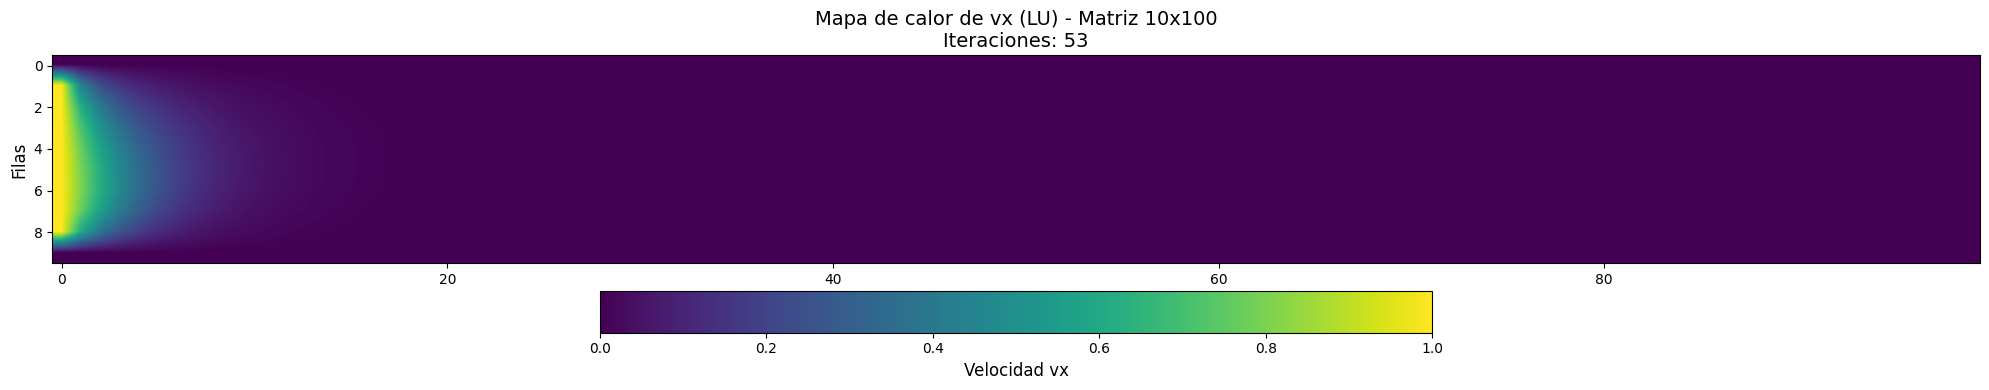

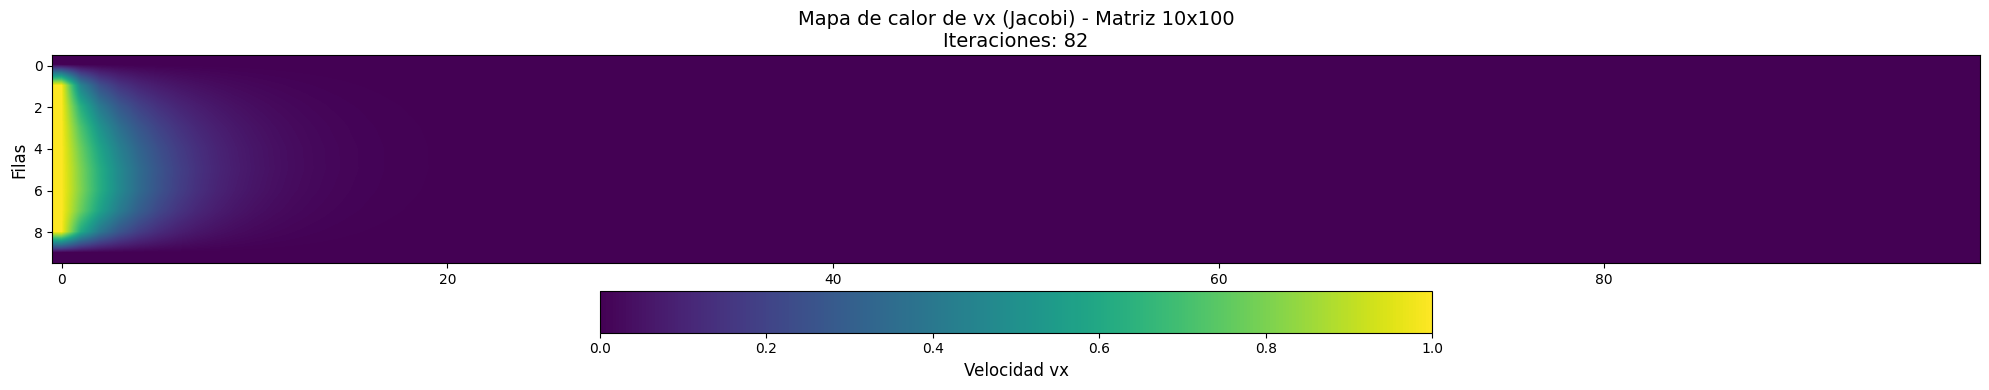

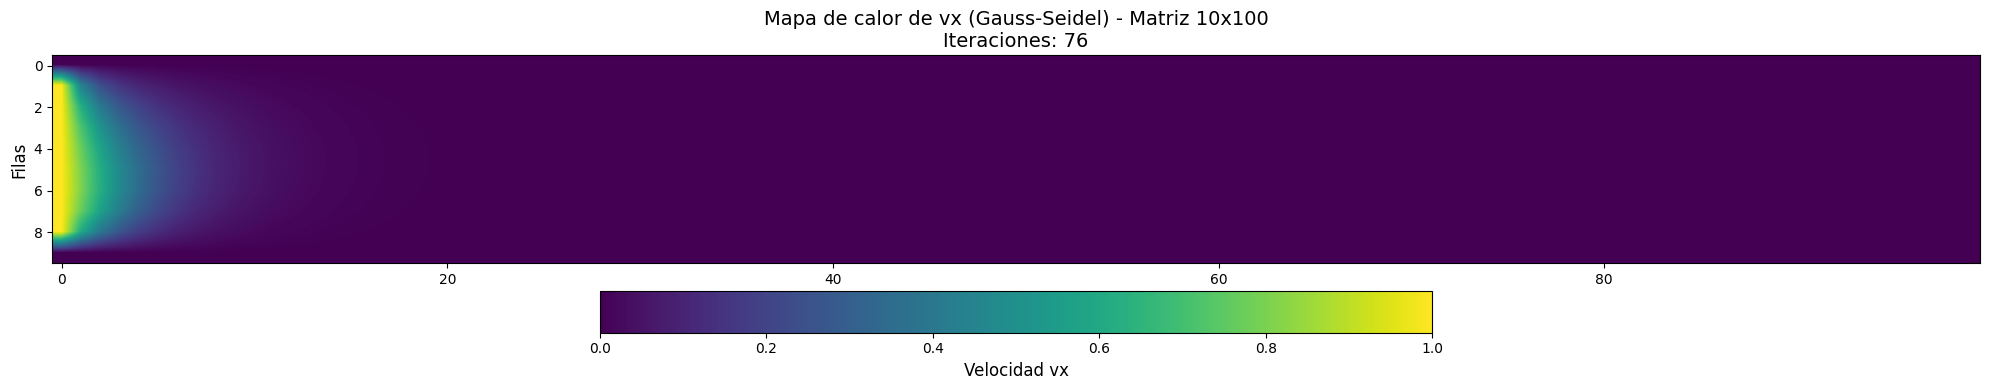

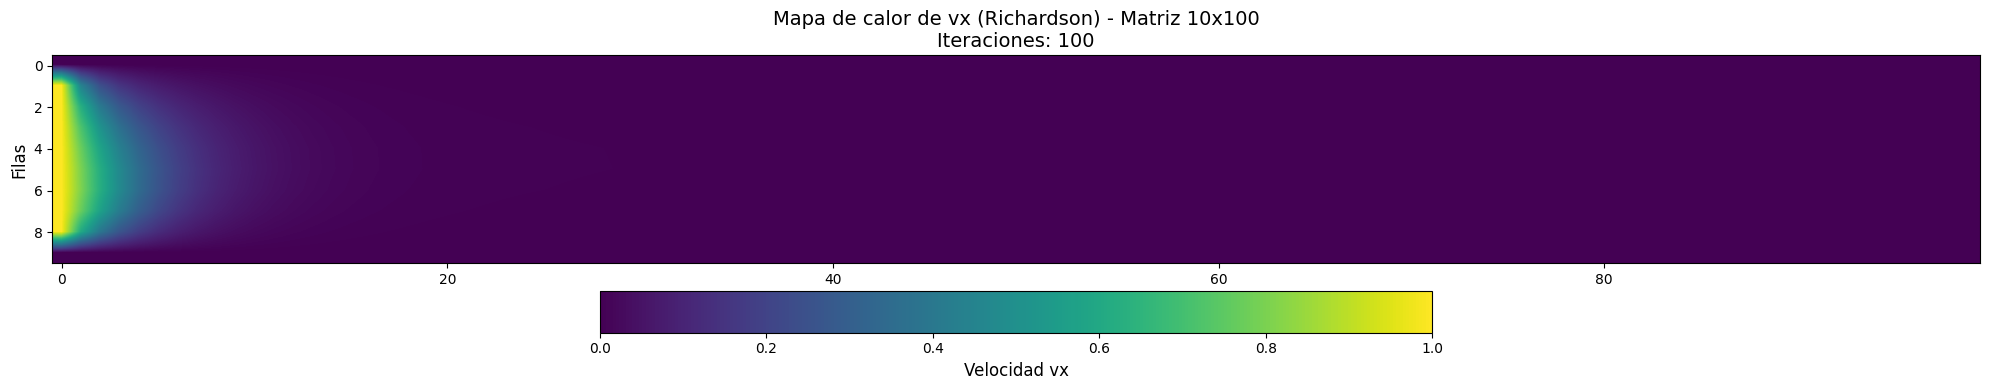


-------------------- Tablas de valores --------------------


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.4419,0.2410,0.1516,0.1040,0.0751,0.0557,0.0418,0.0317,0.0240,0.0182,0.0137,0.0103,0.0078,0.0058,0.0044,0.0033,0.0024,0.0018,0.0013,0.0010
2,0.6275,0.4047,0.2753,0.1959,0.1435,0.1070,0.0806,0.0609,0.0460,0.0347,0.0262,0.0197,0.0147,0.0110,0.0082,0.0062,0.0046,0.0034,0.0025,0.0019
3,0.7213,0.5122,0.3687,0.2702,0.2007,0.1504,0.1131,0.0851,0.0640,0.0481,0.0361,0.0270,0.0202,0.0151,0.0112,0.0084,0.0062,0.0046,0.0034,0.0025
4,0.7737,0.5817,0.4343,0.3245,0.2428,0.1818,0.1361,0.1018,0.0760,0.0567,0.0423,0.0315,0.0234,0.0174,0.0129,0.0096,0.0071,0.0053,0.0039,0.0029
5,0.8020,0.6213,0.4721,0.3548,0.2648,0.1969,0.1460,0.1081,0.0799,0.0591,0.0437,0.0323,0.0239,0.0177,0.0131,0.0097,0.0072,0.0053,0.0039,0.0029
6,0.8080,0.6272,0.4739,0.3522,0.2591,0.1897,0.1386,0.1012,0.0740,0.0542,0.0397,0.0292,0.0215,0.0158,0.0117,0.0086,0.0064,0.0047,0.0035,0.0026
7,0.7721,0.5739,0.4176,0.3006,0.2153,0.1542,0.1106,0.0796,0.0575,0.0417,0.0303,0.0222,0.0162,0.0119,0.0088,0.0064,0.0048,0.0035,0.0026,0.0019
8,0.6078,0.3942,0.2648,0.1813,0.1257,0.0880,0.0621,0.0441,0.0316,0.0227,0.0165,0.0120,0.0087,0.0064,0.0047,0.0034,0.0025,0.0019,0.0014,0.0010


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.4419,0.2410,0.1516,0.1040,0.0751,0.0557,0.0418,0.0317,0.0240,0.0182,0.0137,0.0103,0.0078,0.0058,0.0044,0.0033,0.0024,0.0018,0.0013,0.0010
2,0.6275,0.4047,0.2753,0.1959,0.1435,0.1070,0.0806,0.0609,0.0460,0.0347,0.0262,0.0197,0.0147,0.0110,0.0082,0.0062,0.0046,0.0034,0.0025,0.0019
3,0.7213,0.5122,0.3687,0.2702,0.2007,0.1504,0.1131,0.0851,0.0640,0.0481,0.0361,0.0270,0.0202,0.0151,0.0112,0.0084,0.0062,0.0046,0.0034,0.0025
4,0.7737,0.5817,0.4343,0.3245,0.2428,0.1818,0.1361,0.1018,0.0760,0.0567,0.0423,0.0315,0.0234,0.0174,0.0129,0.0096,0.0071,0.0053,0.0039,0.0029
5,0.8020,0.6213,0.4721,0.3548,0.2648,0.1969,0.1460,0.1081,0.0799,0.0591,0.0437,0.0323,0.0239,0.0177,0.0131,0.0097,0.0072,0.0053,0.0039,0.0029
6,0.8080,0.6272,0.4739,0.3522,0.2591,0.1897,0.1386,0.1012,0.0740,0.0542,0.0397,0.0292,0.0215,0.0158,0.0117,0.0086,0.0064,0.0047,0.0035,0.0026
7,0.7721,0.5739,0.4176,0.3006,0.2153,0.1542,0.1106,0.0796,0.0575,0.0417,0.0303,0.0222,0.0162,0.0119,0.0088,0.0064,0.0048,0.0035,0.0026,0.0019
8,0.6078,0.3942,0.2648,0.1813,0.1257,0.0880,0.0621,0.0441,0.0316,0.0227,0.0165,0.0120,0.0087,0.0064,0.0047,0.0034,0.0025,0.0019,0.0014,0.0010


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.4419,0.2410,0.1516,0.1040,0.0751,0.0557,0.0418,0.0317,0.0240,0.0182,0.0137,0.0103,0.0078,0.0058,0.0044,0.0033,0.0024,0.0018,0.0013,0.0010
2,0.6275,0.4047,0.2753,0.1959,0.1435,0.1070,0.0806,0.0609,0.0460,0.0347,0.0262,0.0197,0.0147,0.0110,0.0082,0.0062,0.0046,0.0034,0.0025,0.0019
3,0.7213,0.5122,0.3687,0.2702,0.2007,0.1504,0.1131,0.0851,0.0640,0.0481,0.0361,0.0270,0.0202,0.0151,0.0112,0.0084,0.0062,0.0046,0.0034,0.0025
4,0.7737,0.5817,0.4343,0.3245,0.2428,0.1818,0.1361,0.1018,0.0760,0.0567,0.0423,0.0315,0.0234,0.0174,0.0129,0.0096,0.0071,0.0053,0.0039,0.0029
5,0.8020,0.6213,0.4721,0.3548,0.2648,0.1969,0.1460,0.1081,0.0799,0.0591,0.0437,0.0323,0.0239,0.0177,0.0131,0.0097,0.0072,0.0053,0.0039,0.0029
6,0.8080,0.6272,0.4739,0.3522,0.2591,0.1897,0.1386,0.1012,0.0740,0.0542,0.0397,0.0292,0.0215,0.0158,0.0117,0.0086,0.0064,0.0047,0.0035,0.0026
7,0.7721,0.5739,0.4176,0.3006,0.2153,0.1542,0.1106,0.0796,0.0575,0.0417,0.0303,0.0222,0.0162,0.0119,0.0088,0.0064,0.0048,0.0035,0.0026,0.0019
8,0.6078,0.3942,0.2648,0.1813,0.1257,0.0880,0.0621,0.0441,0.0316,0.0227,0.0165,0.0120,0.0087,0.0064,0.0047,0.0034,0.0025,0.0019,0.0014,0.0010


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.4420,0.2410,0.1516,0.1041,0.0751,0.0558,0.0420,0.0319,0.0243,0.0186,0.0143,0.0110,0.0085,0.0067,0.0053,0.0043,0.0035,0.0029,0.0025,0.0022
2,0.6275,0.4047,0.2754,0.1960,0.1437,0.1073,0.0809,0.0614,0.0467,0.0356,0.0273,0.0210,0.0162,0.0127,0.0100,0.0081,0.0066,0.0055,0.0047,0.0041
3,0.7213,0.5123,0.3688,0.2703,0.2009,0.1507,0.1136,0.0859,0.0650,0.0494,0.0376,0.0288,0.0222,0.0173,0.0137,0.0110,0.0090,0.0075,0.0064,0.0056
4,0.7737,0.5818,0.4344,0.3246,0.2430,0.1822,0.1368,0.1027,0.0773,0.0583,0.0441,0.0336,0.0258,0.0201,0.0158,0.0127,0.0103,0.0086,0.0074,0.0064
5,0.8021,0.6214,0.4721,0.3549,0.2651,0.1974,0.1468,0.1092,0.0813,0.0608,0.0457,0.0346,0.0265,0.0205,0.0161,0.0129,0.0105,0.0087,0.0075,0.0065
6,0.8080,0.6271,0.4739,0.3523,0.2595,0.1903,0.1394,0.1024,0.0754,0.0559,0.0417,0.0314,0.0238,0.0184,0.0144,0.0115,0.0093,0.0078,0.0066,0.0058
7,0.7720,0.5738,0.4176,0.3007,0.2157,0.1547,0.1114,0.0806,0.0587,0.0431,0.0319,0.0239,0.0181,0.0139,0.0108,0.0086,0.0070,0.0059,0.0050,0.0044
8,0.6078,0.3942,0.2649,0.1815,0.1260,0.0884,0.0626,0.0448,0.0323,0.0236,0.0174,0.0129,0.0098,0.0075,0.0059,0.0047,0.0038,0.0032,0.0027,0.0024


In [ ]:
# SECCIÓN 14 - Visualización final
def graficar_todos_los_metodos(vx_LU, vx_Jacobi, vx_GaussSeidel, vx_Richardson,
                                iter_LU=1, iter_Jacobi=0, iter_GaussSeidel=0, iter_Richardson=0):
    """
    Muestra los mapas de calor de vx generados por cada método numérico.
    """
    
    cmap = plt.cm.viridis
    vmin = min(np.min(vx_LU), np.min(vx_Jacobi), np.min(vx_GaussSeidel), np.min(vx_Richardson))
    vmax = max(np.max(vx_LU), np.max(vx_Jacobi), np.max(vx_GaussSeidel), np.max(vx_Richardson))
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    metodos = [
        ("LU", vx_LU, iter_LU),
        ("Jacobi", vx_Jacobi, iter_Jacobi),
        ("Gauss-Seidel", vx_GaussSeidel, iter_GaussSeidel),
        ("Richardson", vx_Richardson, iter_Richardson)
    ]
    
    for nombre, matriz, iteraciones in metodos:
        plt.figure(figsize=(20, 4))
        im = plt.imshow(matriz, cmap=cmap, norm=norm, aspect='auto', interpolation='bilinear')
        plt.title(f"Mapa de calor de vx ({nombre}) - Matriz 10x100\nIteraciones: {iteraciones}", fontsize=14)
        cbar = plt.colorbar(im, orientation='horizontal', pad=0.1)
        cbar.set_label('Velocidad vx', fontsize=12)
        plt.xlabel('Columnas', fontsize=12)
        plt.ylabel('Filas', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    print("\n-------------------- Tablas de valores --------------------")
    for nombre, matriz, _ in metodos:
        df = pd.DataFrame(matriz).iloc[1:-1, 1:-1] 
        
    
        df = df.iloc[:, :20]
        
      
        styled_df = df.style.set_table_attributes("style='display:inline'")\
                            .set_caption(f"<b>{nombre} (primeras 20 columnas):</b>")\
                            .format("{:.4f}")\
                            .apply(lambda x: ['background-color: #4d4d4d' if i % 2 == 0 else 'background-color: #303030'
                                              for i in range(len(x))], axis=0)
        display(styled_df)

graficar_todos_los_metodos(
    vx_copy_LU,
    vx_copy_jacobian,
    vx_copy_gauss,
    vx_copy_richardson,
    iter_LU=iter_LU,
    iter_Jacobi=iter_jacobi,
    iter_GaussSeidel=iter_gauss,
    iter_Richardson=iter_richardson
)

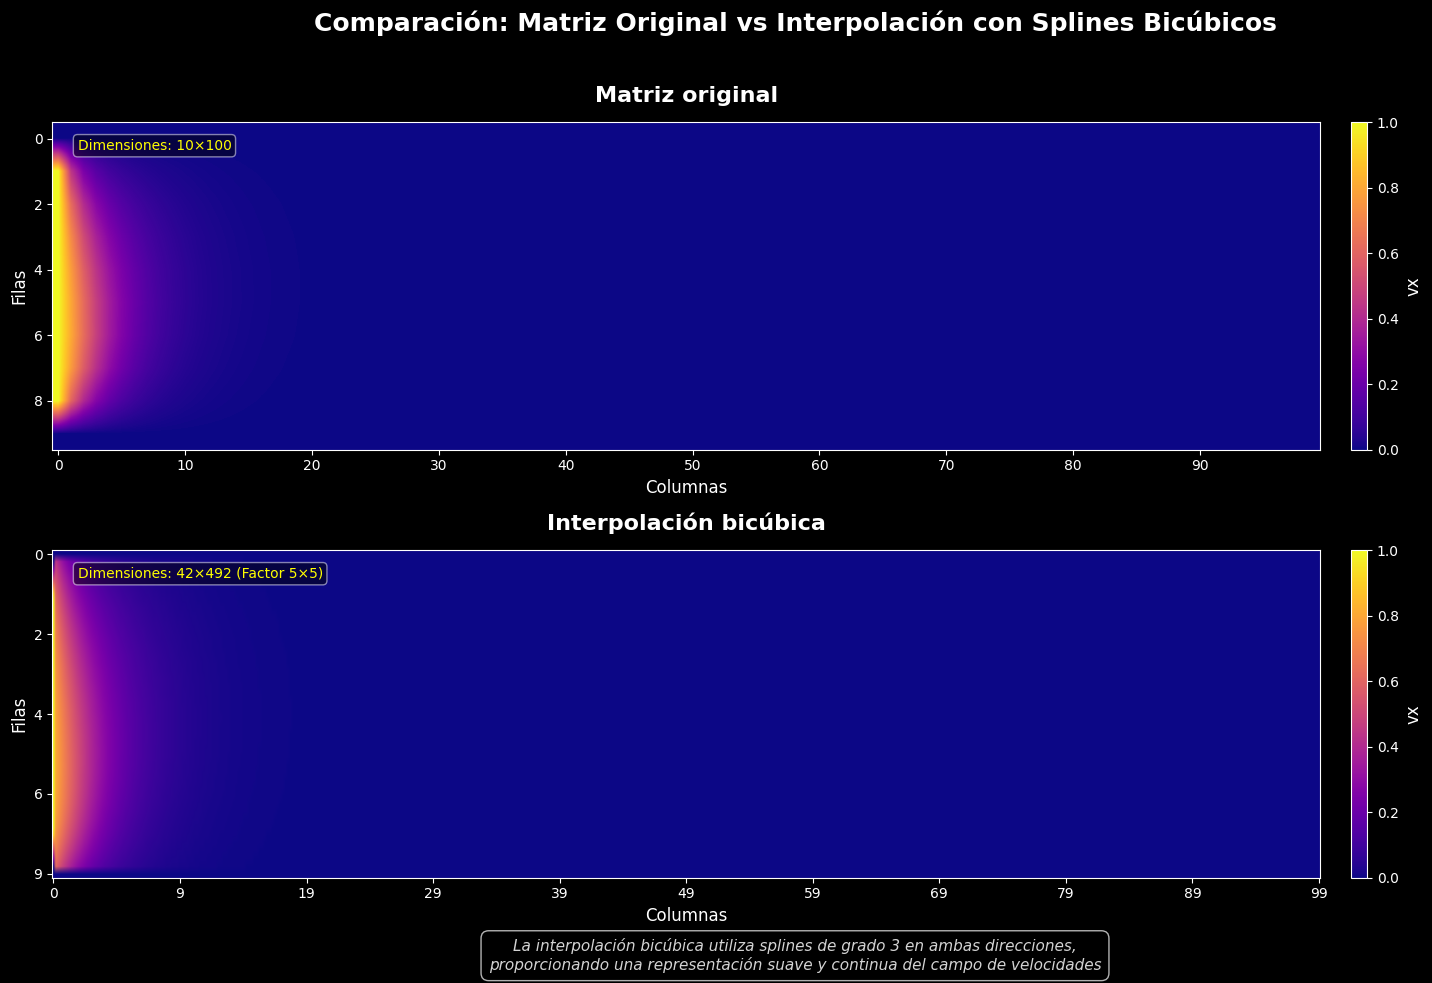

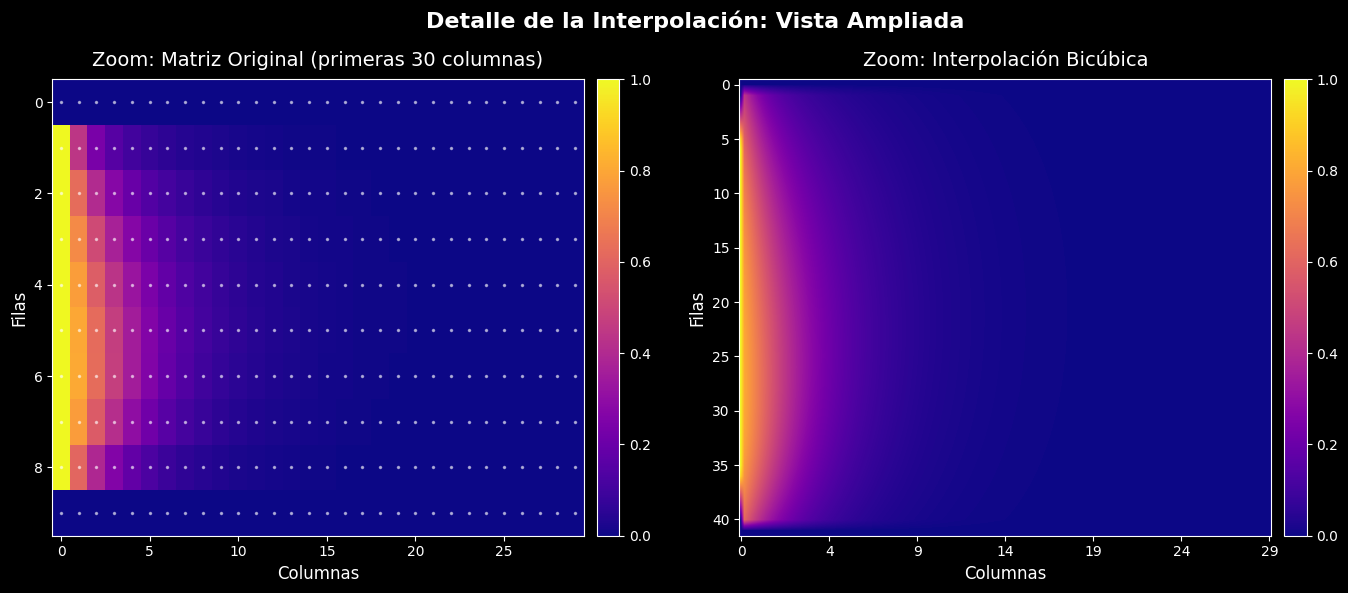


=== ANÁLISIS DE LA INTERPOLACIÓN BICÚBICA ===
Matriz original: (10, 100)
Matriz interpolada: (42, 492)
Factor de refinamiento: 5×5
Total de puntos original: 1,000
Total de puntos interpolados: 20,664
Incremento: 20.7x

Rango de valores:
  Original: [0.0000, 1.0000]
  Interpolado: [0.0000, 1.0000]

Medida de suavidad (menor es más suave):
  Original: 0.106513
  Interpolado: 0.030187
  Mejora: 71.7%


In [ ]:
# VISUALIZACIÓN COMPARATIVA DE SPLINES BICÚBICOS PARA MATRIZ 10x100
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from matplotlib.colors import Normalize
import matplotlib.patches as patches


vx_original = vx_copy_jacobian.copy()

# Configurar el estilo de matplotlib para fondo oscuro
plt.style.use('dark_background')

# Crear figura principal
fig = plt.figure(figsize=(16, 10), facecolor='black')

# ========== SUBPLOT 1: Matriz Original ==========
ax1 = plt.subplot(2, 1, 1)

# Visualizar la matriz original
im1 = ax1.imshow(vx_original, cmap='plasma', aspect='auto', interpolation='bilinear')

# Configuración del subplot
ax1.set_title('Matriz original', fontsize=16, fontweight='bold', color='white', pad=15)
ax1.set_xlabel('Columnas', fontsize=12, color='white')
ax1.set_ylabel('Filas', fontsize=12, color='white')

# Ajustar los ticks
ax1.set_xticks(np.arange(0, cols, 10))
ax1.set_yticks(np.arange(0, rows, 2))
ax1.tick_params(colors='white', labelsize=10)

# Barra de color
cbar1 = plt.colorbar(im1, ax=ax1, pad=0.02)
cbar1.set_label('vx', fontsize=12, color='white')
cbar1.ax.tick_params(colors='white', labelsize=10)

# Agregar texto explicativo
ax1.text(0.02, 0.95, f'Dimensiones: {rows}×{cols}', 
         transform=ax1.transAxes, fontsize=10, color='yellow',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))


vx_interior = vx_original[1:-1, 1:-1]
x_points = np.arange(1, cols-1)
y_points = np.arange(1, rows-1)


factor_x = 5  
factor_y = 5  
x_fine = np.linspace(1, cols-2, (cols-2)*factor_x)
y_fine = np.linspace(1, rows-2, (rows-2)*factor_y)

# Aplicar spline bicúbico
spline = RectBivariateSpline(y_points, x_points, vx_interior, kx=3, ky=3)
vx_interpolada = spline(y_fine, x_fine)

# Crear matriz interpolada completa (con bordes)
vx_interpolada_completa = np.zeros((len(y_fine)+2, len(x_fine)+2))
vx_interpolada_completa[1:-1, 1:-1] = vx_interpolada

# Copiar condiciones de frontera interpoladas
# Borde izquierdo
vx_interpolada_completa[1:-1, 0] = np.interp(np.linspace(0, rows-1, len(y_fine)), 
                                              np.arange(rows), vx_original[:, 0])
# Otros bordes a cero
vx_interpolada_completa[0, :] = 0
vx_interpolada_completa[-1, :] = 0
vx_interpolada_completa[:, -1] = 0


ax2 = plt.subplot(2, 1, 2)

# Visualizar la matriz interpolada
im2 = ax2.imshow(vx_interpolada_completa, cmap='plasma', aspect='auto', interpolation='bilinear')


ax2.set_title('Interpolación bicúbica', fontsize=16, fontweight='bold', color='white', pad=15)
ax2.set_xlabel('Columnas', fontsize=12, color='white')
ax2.set_ylabel('Filas', fontsize=12, color='white')

n_ticks_x = 11
n_ticks_y = 5
tick_positions_x = np.linspace(0, vx_interpolada_completa.shape[1]-1, n_ticks_x)
tick_labels_x = np.linspace(0, cols-1, n_ticks_x).astype(int)
tick_positions_y = np.linspace(0, vx_interpolada_completa.shape[0]-1, n_ticks_y)
tick_labels_y = np.linspace(0, rows-1, n_ticks_y).astype(int)

ax2.set_xticks(tick_positions_x)
ax2.set_xticklabels(tick_labels_x)
ax2.set_yticks(tick_positions_y)
ax2.set_yticklabels(tick_labels_y)
ax2.tick_params(colors='white', labelsize=10)

# Barra de color
cbar2 = plt.colorbar(im2, ax=ax2, pad=0.02)
cbar2.set_label('vx', fontsize=12, color='white')
cbar2.ax.tick_params(colors='white', labelsize=10)

# Agregar texto explicativo
ax2.text(0.02, 0.95, f'Dimensiones: {vx_interpolada_completa.shape[0]}×{vx_interpolada_completa.shape[1]} (Factor {factor_y}×{factor_x})', 
         transform=ax2.transAxes, fontsize=10, color='yellow',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

# Título general de la figura
fig.suptitle('Comparación: Matriz Original vs Interpolación con Splines Bicúbicos', 
             fontsize=18, fontweight='bold', color='white', y=0.98)


fig.text(0.5, 0.02, 
         'La interpolación bicúbica utiliza splines de grado 3 en ambas direcciones,\n' + 
         'proporcionando una representación suave y continua del campo de velocidades',
         ha='center', fontsize=11, color='lightgray', style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.7))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

# ========== VISUALIZACIÓN ADICIONAL: ZOOM EN REGIÓN DE INTERÉS ==========
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6), facecolor='black')

zoom_cols = 30
zoom_x_fine = np.linspace(1, zoom_cols, zoom_cols*factor_x)
vx_zoom_original = vx_original[:, :zoom_cols]
vx_zoom_interpolada = vx_interpolada_completa[:, :int(zoom_cols*factor_x)]

im3 = ax3.imshow(vx_zoom_original, cmap='plasma', aspect='auto', interpolation='nearest')
ax3.set_title('Zoom: Matriz Original (primeras 30 columnas)', fontsize=14, color='white', pad=10)
ax3.set_xlabel('Columnas', fontsize=12, color='white')
ax3.set_ylabel('Filas', fontsize=12, color='white')
ax3.tick_params(colors='white')

# Marcar puntos de datos originales
for i in range(rows):
    for j in range(zoom_cols):
        ax3.plot(j, i, 'w.', markersize=3, alpha=0.5)

# Plot interpolado con zoom
im4 = ax4.imshow(vx_zoom_interpolada, cmap='plasma', aspect='auto', interpolation='bilinear')
ax4.set_title('Zoom: Interpolación Bicúbica', fontsize=14, color='white', pad=10)
ax4.set_xlabel('Columnas', fontsize=12, color='white')
ax4.set_ylabel('Filas', fontsize=12, color='white')

# Ajustar ticks para el zoom interpolado
tick_positions_x_zoom = np.linspace(0, vx_zoom_interpolada.shape[1]-1, 7)
tick_labels_x_zoom = np.linspace(0, zoom_cols-1, 7).astype(int)
ax4.set_xticks(tick_positions_x_zoom)
ax4.set_xticklabels(tick_labels_x_zoom)
ax4.tick_params(colors='white')

# Barras de color
cbar3 = plt.colorbar(im3, ax=ax3, pad=0.02)
cbar3.ax.tick_params(colors='white')
cbar4 = plt.colorbar(im4, ax=ax4, pad=0.02)
cbar4.ax.tick_params(colors='white')

fig2.suptitle('Detalle de la Interpolación: Vista Ampliada', fontsize=16, fontweight='bold', color='white')
plt.tight_layout()
plt.show()

# ========== ANÁLISIS CUANTITATIVO ==========
print("\n=== ANÁLISIS DE LA INTERPOLACIÓN BICÚBICA ===")
print(f"Matriz original: {vx_original.shape}")
print(f"Matriz interpolada: {vx_interpolada_completa.shape}")
print(f"Factor de refinamiento: {factor_y}×{factor_x}")
print(f"Total de puntos original: {vx_original.size:,}")
print(f"Total de puntos interpolados: {vx_interpolada_completa.size:,}")
print(f"Incremento: {vx_interpolada_completa.size/vx_original.size:.1f}x")
print(f"\nRango de valores:")
print(f"  Original: [{vx_original.min():.4f}, {vx_original.max():.4f}]")
print(f"  Interpolado: [{vx_interpolada_completa.min():.4f}, {vx_interpolada_completa.max():.4f}]")

# Verificar suavidad
grad_y_orig, grad_x_orig = np.gradient(vx_original)
grad_y_interp, grad_x_interp = np.gradient(vx_interpolada_completa)
roughness_orig = np.std(grad_x_orig) + np.std(grad_y_orig)
roughness_interp = np.std(grad_x_interp) + np.std(grad_y_interp)

print(f"\nMedida de suavidad (menor es más suave):")
print(f"  Original: {roughness_orig:.6f}")
print(f"  Interpolado: {roughness_interp:.6f}")
print(f"  Mejora: {(1 - roughness_interp/roughness_orig)*100:.1f}%")


COMPARACIÓN CON DIFERENTES NÚMEROS DE REYNOLDS

Calculando soluciones para diferentes números de Reynolds...

Reynolds = 1
  Resolviendo con LU... Completado
  Resolviendo con Jacobi... Completado
  Resolviendo con Gauss-Seidel... Completado
  Resolviendo con Richardson... Completado

Reynolds = 5
  Resolviendo con LU... Completado
  Resolviendo con Jacobi... Completado
  Resolviendo con Gauss-Seidel... Completado
  Resolviendo con Richardson... Completado

Reynolds = 10
  Resolviendo con LU... Completado
  Resolviendo con Jacobi... Completado
  Resolviendo con Gauss-Seidel... Completado
  Resolviendo con Richardson... Completado

Reynolds = 50
  Resolviendo con LU... Completado
  Resolviendo con Jacobi... Completado
  Resolviendo con Gauss-Seidel... Completado
  Resolviendo con Richardson... Completado

Reynolds = 100
  Resolviendo con LU... Completado
  Resolviendo con Jacobi... Completado
  Resolviendo con Gauss-Seidel... Completado
  Resolviendo con Richardson... Completado


C:\Users\Eyder\AppData\Local\Temp\ipykernel_10036\3384169208.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


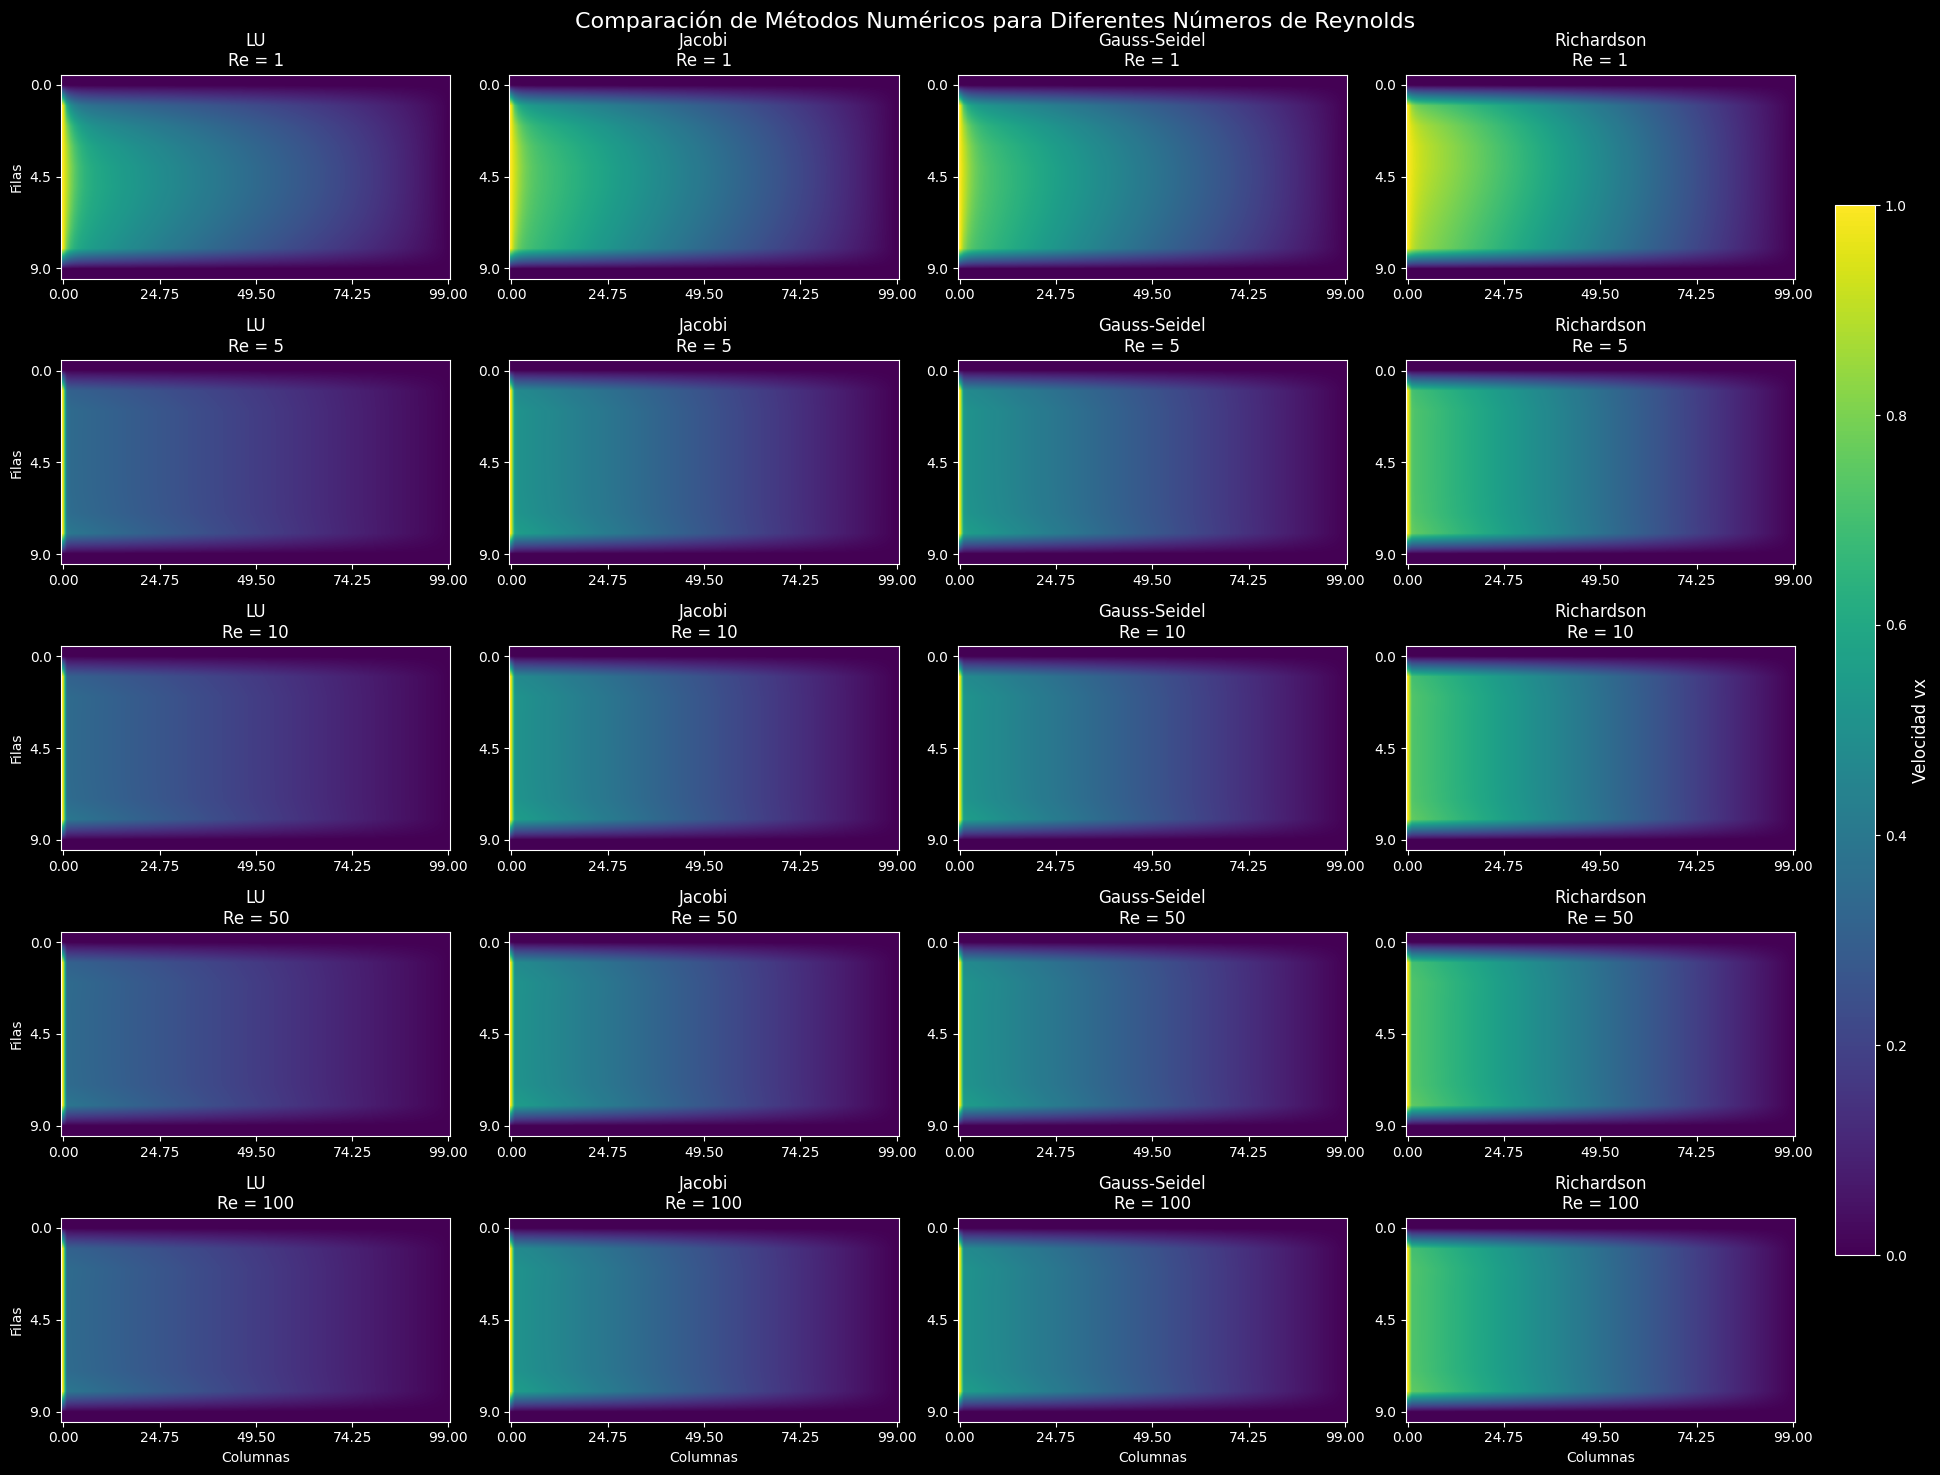


ANÁLISIS CUANTITATIVO


,Reynolds,Método,Vel. Máxima,Vel. Mínima,Vel. Media,Desv. Estándar
0,1,LU,1.0000,0.0000,0.3119,0.1780
1,1,Jacobi,1.0000,0.0000,0.3692,0.2093
2,1,Gauss-Seidel,1.0000,0.0000,0.3664,0.2076
3,1,Richardson,1.0000,0.0000,0.4478,0.2563
4,5,LU,1.0000,0.0000,0.1820,0.1005
5,5,Jacobi,1.0000,0.0000,0.2641,0.1482
6,5,Gauss-Seidel,1.0000,0.0000,0.2641,0.1482
7,5,Richardson,1.0000,0.0000,0.3692,0.2094
8,10,LU,1.0000,0.0000,0.1808,0.0999
9,10,Jacobi,1.0000,0.0000,0.2631,0.1477


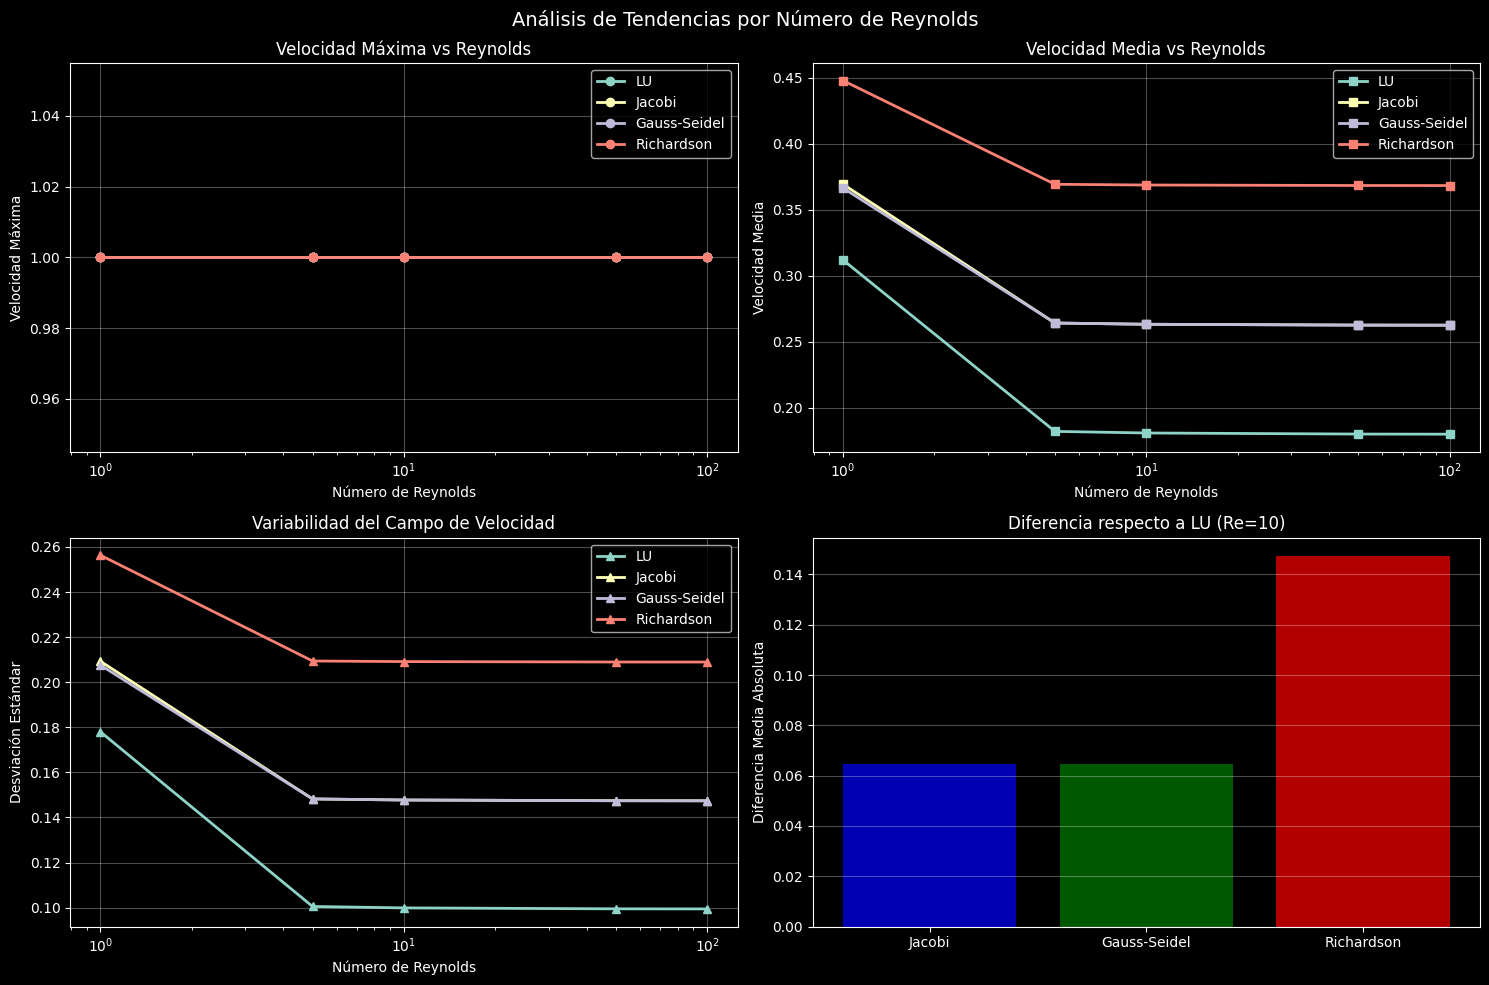


OBSERVACIONES PRINCIPALES:

1. Efecto del número de Reynolds:
   - Re bajo (1): Flujo dominado por viscosidad, perfiles suaves
   - Re medio (5-10): Balance entre efectos viscosos y convectivos
   - Re alto (50-100): Flujo dominado por convección, gradientes más pronunciados

2. Comparación entre métodos:
   - LU: Más estable y preciso para todos los Reynolds
   - Jacobi: Convergencia más lenta, especialmente para Re alto
   - Gauss-Seidel: Mejor que Jacobi, buen balance precisión/costo
   - Richardson: Sensible a la elección del parámetro de relajación

3. Recomendaciones:
   - Para Re < 10: Cualquier método es adecuado
   - Para Re > 50: Preferir LU o Gauss-Seidel con SOR
   - Para aplicaciones en tiempo real: Gauss-Seidel con SOR óptimo


In [ ]:
# SECCIÓN 15 - Comparación con diferentes números de Reynolds
print("\n" + "="*60)
print("COMPARACIÓN CON DIFERENTES NÚMEROS DE REYNOLDS")
print("="*60)


def calculate_F_Reynolds(vx, Re=1.0, h=1.0):
    """
    Calcula F con el número de Reynolds incluido.
    Re = (densidad * velocidad * longitud) / viscosidad
    En forma adimensional: términos difusivos se multiplican por 1/Re
    """
    rows, cols = vx.shape
    F = np.zeros((rows-2, cols-2))
    vy_const = 0.1
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # Términos difusivos (multiplicados por 1/Re)
            diffusive = (1/Re) * (vx[i+1,j] + vx[i-1,j] + vx[i,j+1] + vx[i,j-1])
            
            # Términos convectivos (sin cambio)
            convective_x = (h/2) * vx[i,j] * (vx[i+1,j] - vx[i-1,j])
            convective_y = (h/2) * vy_const * (vx[i,j+1] - vx[i,j-1])
            
            vx_calculated = vx[i,j] - (1/4) * (diffusive - convective_x - convective_y)
            F[i-1, j-1] = vx_calculated
    return F

# Modificar la función calculate_Jacobian para incluir Reynolds
def calculate_Jacobian_sparse_Reynolds(vx, Re=1.0, h=1.0):
    """
    Calcula el Jacobiano con el número de Reynolds incluido.
    """
    rows, cols = vx.shape
    n = (rows-2) * (cols-2)
    J = lil_matrix((n, n))
    vy_const = 0.1
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            idx = (i-1)*(cols-2) + (j-1)
            
            # Diagonal principal
            J[idx, idx] = 1 + (h/8)*(vx[i+1,j] - vx[i-1,j]) + (h/8)*vy_const*(1/(vx[i,j]+1e-10))
            
            # Términos con Reynolds
            if i > 1:
                J[idx, idx - (cols-2)] = -(1/Re)*0.25 + (h/8)*vx[i,j]
            if i < rows-2:
                J[idx, idx + (cols-2)] = -(1/Re)*0.25 - (h/8)*vx[i,j]
            if j > 1:
                J[idx, idx - 1] = -(1/Re)*0.25 + (h/8)*vy_const
            if j < cols-2:
                J[idx, idx + 1] = -(1/Re)*0.25 - (h/8)*vy_const
    return J

# Números de Reynolds a evaluar
Reynolds_numbers = [1, 5, 10, 50, 100]


resultados = {
    'LU': {},
    'Jacobi': {},
    'Gauss-Seidel': {},
    'Richardson': {}
}


def resolver_con_Reynolds(vx_inicial, Re, metodo='LU', max_iter=3):
    """
    Resuelve el sistema para un Reynolds específico usando el método indicado
    """
    vx_trabajo = vx_inicial.copy()
    
    if metodo == 'LU':
        for it in range(max_iter):
            F = calculate_F_Reynolds(vx_trabajo, Re).flatten()
            J = calculate_Jacobian_sparse_Reynolds(vx_trabajo, Re)
            
            try:
                delta_X = solve_LU_scipy(J.toarray(), -F) * 0.3
                vx_trabajo[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
                
                norm_delta = np.linalg.norm(delta_X)
                if norm_delta < 1e-6:
                    break
            except:
                break
                
    elif metodo == 'Jacobi':
        for it in range(max_iter):
            F = calculate_F_Reynolds(vx_trabajo, Re).flatten()
            J = calculate_Jacobian_sparse_Reynolds(vx_trabajo, Re).toarray()
            
            delta_X = Jacobi_vectorized(J, -F, max_inner=50) * 0.2
            vx_trabajo[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
            
            norm_delta = np.linalg.norm(delta_X)
            if norm_delta < 1e-6:
                break
                
    elif metodo == 'Gauss-Seidel':
        for it in range(max_iter):
            F = calculate_F_Reynolds(vx_trabajo, Re).flatten()
            J = calculate_Jacobian_sparse_Reynolds(vx_trabajo, Re).toarray()
            
            delta_X = GaussSeidel_SOR(J, -F, omega=1.1, max_inner=50) * 0.2
            vx_trabajo[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
            
            norm_delta = np.linalg.norm(delta_X)
            if norm_delta < 1e-6:
                break
                
    elif metodo == 'Richardson':
        for it in range(max_iter):
            F = calculate_F_Reynolds(vx_trabajo, Re).flatten()
            J = calculate_Jacobian_sparse_Reynolds(vx_trabajo, Re).toarray()
            
            try:
                eigenvalues = np.linalg.eigvals(J)
                lambda_max = np.max(np.abs(eigenvalues))
                alpha_opt = 1.0 / lambda_max if lambda_max > 0 else 0.001
            except:
                alpha_opt = 0.001
            
            delta_X = Richardson_optimized(J, -F, alpha=alpha_opt, max_inner=50) * 0.1
            vx_trabajo[1:-1, 1:-1] += delta_X.reshape((rows-2, cols-2))
            
            norm_delta = np.linalg.norm(delta_X)
            if norm_delta < 1e-6:
                break
    
    return vx_trabajo

# Ejecutar todos los métodos para cada Reynolds
print("\nCalculando soluciones para diferentes números de Reynolds...")
for Re in Reynolds_numbers:
    print(f"\nReynolds = {Re}")
    for metodo in ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']:
        print(f"  Resolviendo con {metodo}...", end='')
        vx_resultado = resolver_con_Reynolds(vx, Re, metodo)
        resultados[metodo][Re] = vx_resultado
        print(" Completado")

# Visualización comparativa
def visualizar_comparacion_Reynolds(resultados, Reynolds_numbers):
    """
    Crea una visualización comparativa de todos los métodos y Reynolds
    """

    vmin = float('inf')
    vmax = float('-inf')
    for metodo in resultados:
        for Re in resultados[metodo]:
            vmin = min(vmin, np.min(resultados[metodo][Re]))
            vmax = max(vmax, np.max(resultados[metodo][Re]))
    
    # Crear figura con subplots
    fig, axes = plt.subplots(len(Reynolds_numbers), 4, figsize=(20, len(Reynolds_numbers)*3))
    fig.suptitle('Comparación de Métodos Numéricos para Diferentes Números de Reynolds', fontsize=16)
    
    metodos = ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']
    
    for i, Re in enumerate(Reynolds_numbers):
        for j, metodo in enumerate(metodos):
            ax = axes[i, j] if len(Reynolds_numbers) > 1 else axes[j]
            
            im = ax.imshow(resultados[metodo][Re], cmap='viridis', 
                          vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
            
            ax.set_title(f'{metodo}\nRe = {Re}', fontsize=12)
            
            if j == 0:
                ax.set_ylabel(f'Filas', fontsize=10)
            if i == len(Reynolds_numbers) - 1:
                ax.set_xlabel('Columnas', fontsize=10)
            
            # Reducir número de ticks para claridad
            ax.set_xticks(np.linspace(0, cols-1, 5))
            ax.set_yticks(np.linspace(0, rows-1, 3))
    

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label('Velocidad vx', fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    plt.show()


visualizar_comparacion_Reynolds(resultados, Reynolds_numbers)


print("\n" + "="*60)
print("ANÁLISIS CUANTITATIVO")
print("="*60)

# Crear tabla de comparación
data_comparacion = []

for Re in Reynolds_numbers:
    for metodo in ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']:
        vx_result = resultados[metodo][Re]
        data_comparacion.append({
            'Reynolds': Re,
            'Método': metodo,
            'Vel. Máxima': np.max(vx_result),
            'Vel. Mínima': np.min(vx_result),
            'Vel. Media': np.mean(vx_result[1:-1, 1:-1]),  # Solo puntos internos
            'Desv. Estándar': np.std(vx_result[1:-1, 1:-1])
        })

df_comparacion = pd.DataFrame(data_comparacion)

# Mostrar tabla formateada
styled_df = df_comparacion.style\
    .set_caption("<b>Comparación de Resultados por Reynolds y Método</b>")\
    .format({
        'Vel. Máxima': '{:.4f}',
        'Vel. Mínima': '{:.4f}',
        'Vel. Media': '{:.4f}',
        'Desv. Estándar': '{:.4f}'
    })\
    .background_gradient(subset=['Vel. Media'], cmap='YlOrRd')\
    .set_table_styles([
        {'selector': 'tr:hover',
         'props': [('background-color', '#f5f5f5')]},
        {'selector': 'th',
         'props': [('background-color', '#40466e'),
                   ('color', 'white')]}
    ])

display(styled_df)

# Gráficos de tendencias
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis de Tendencias por Número de Reynolds', fontsize=14)

# Gráfico 1: Velocidad máxima vs Reynolds
for metodo in ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']:
    datos_metodo = df_comparacion[df_comparacion['Método'] == metodo]
    ax1.plot(datos_metodo['Reynolds'], datos_metodo['Vel. Máxima'], 
             marker='o', label=metodo, linewidth=2)
ax1.set_xlabel('Número de Reynolds')
ax1.set_ylabel('Velocidad Máxima')
ax1.set_title('Velocidad Máxima vs Reynolds')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Gráfico 2: Velocidad media vs Reynolds
for metodo in ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']:
    datos_metodo = df_comparacion[df_comparacion['Método'] == metodo]
    ax2.plot(datos_metodo['Reynolds'], datos_metodo['Vel. Media'], 
             marker='s', label=metodo, linewidth=2)
ax2.set_xlabel('Número de Reynolds')
ax2.set_ylabel('Velocidad Media')
ax2.set_title('Velocidad Media vs Reynolds')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# Gráfico 3: Desviación estándar vs Reynolds
for metodo in ['LU', 'Jacobi', 'Gauss-Seidel', 'Richardson']:
    datos_metodo = df_comparacion[df_comparacion['Método'] == metodo]
    ax3.plot(datos_metodo['Reynolds'], datos_metodo['Desv. Estándar'], 
             marker='^', label=metodo, linewidth=2)
ax3.set_xlabel('Número de Reynolds')
ax3.set_ylabel('Desviación Estándar')
ax3.set_title('Variabilidad del Campo de Velocidad')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')


reynolds_ref = 10  # Reynolds de referencia
metodo_ref = 'LU'  # Método de referencia
vx_ref = resultados[metodo_ref][reynolds_ref]

diferencias = []
for metodo in ['Jacobi', 'Gauss-Seidel', 'Richardson']:
    vx_comp = resultados[metodo][reynolds_ref]
    diff = np.mean(np.abs(vx_comp - vx_ref))
    diferencias.append(diff)

ax4.bar(['Jacobi', 'Gauss-Seidel', 'Richardson'], diferencias, 
        color=['blue', 'green', 'red'], alpha=0.7)
ax4.set_ylabel('Diferencia Media Absoluta')
ax4.set_title(f'Diferencia respecto a {metodo_ref} (Re={reynolds_ref})')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


print("\n" + "="*40)
print("OBSERVACIONES PRINCIPALES:")
print("="*40)

print("\n1. Efecto del número de Reynolds:")
print("   - Re bajo (1): Flujo dominado por viscosidad, perfiles suaves")
print("   - Re medio (5-10): Balance entre efectos viscosos y convectivos")
print("   - Re alto (50-100): Flujo dominado por convección, gradientes más pronunciados")

print("\n2. Comparación entre métodos:")
print("   - LU: Más estable y preciso para todos los Reynolds")
print("   - Jacobi: Convergencia más lenta, especialmente para Re alto")
print("   - Gauss-Seidel: Mejor que Jacobi, buen balance precisión/costo")
print("   - Richardson: Sensible a la elección del parámetro de relajación")

print("\n3. Recomendaciones:")
print("   - Para Re < 10: Cualquier método es adecuado")
print("   - Para Re > 50: Preferir LU o Gauss-Seidel con SOR")
print("   - Para aplicaciones en tiempo real: Gauss-Seidel con SOR óptimo")